# Yelp Sentiment Analysis with doc2vec Document Vectors

## Imports & Settings

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import logging
import warnings
from random import shuffle
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import class_weight
import seaborn as sns

### Settings

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

### Paths

In [4]:
yelp_path = Path('data', 'doc2vec')

### Logging Config

In [5]:
logging.basicConfig(
        filename=yelp_path / 'doc2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Load Data

Refer to download information in [yelp_sentiment](../14_working_with_text_data/06_sentiment_analysis_yelp.ipynb)

In [6]:
df = pd.read_parquet(yelp_path / 'combined.parquet').loc[:, ['stars', 'text']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996995 entries, 0 to 5996995
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   stars   int64 
 1   text    object
dtypes: int64(1), object(1)
memory usage: 137.3+ MB


In [8]:
df.stars.value_counts()

5    2641880
4    1335957
1     858139
3     673206
2     487813
Name: stars, dtype: int64

In [9]:
stars = range(1, 6)

In [10]:
sample = pd.concat([df[df.stars==s].sample(n=100000) for s in stars])

In [11]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 1701708 to 5940716
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   500000 non-null  int64 
 1   text    500000 non-null  object
dtypes: int64(1), object(1)
memory usage: 11.4+ MB


In [12]:
sample.stars.value_counts()

5    100000
4    100000
3    100000
2    100000
1    100000
Name: stars, dtype: int64

In [13]:
sample.to_parquet('yelp_sample.parquet')

In [14]:
sample = pd.read_parquet('yelp_sample.parquet').reset_index(drop=True)

In [15]:
sample.head()

,stars,text
0,1,"Horrible service, would walk away every time I..."
1,1,This is one of the worst Uhaul dealers I've ev...
2,1,Finally cancelled after a couple years because...
3,1,This one star review is for the reception I re...
4,1,If It could be lower it would be.\n\n I Found...


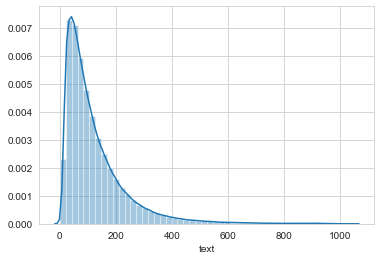

In [16]:
sns.distplot(sample.text.str.split().str.len());

## Doc2Vec

### Basic text cleaning

In [17]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def clean(review):
    tokens = tokenizer.tokenize(review)
    return ' '.join([t for t in tokens if t not in stopword_set])

In [18]:
sample.text = sample.text.str.lower().apply(clean)

In [19]:
sample.sample(n=10)

,stars,text
187506,2,average reading multiple site reviews showed a...
307399,4,experience golfland mini golf played three fou...
60425,1,place sucks food bad waitresses nasty suck job...
206664,3,group 6 popped dinner prior seeing rent panaso...
214651,3,moved town trying find go indian restaurant un...
437115,5,went ayce sushi simply bomb com end story ok t...
84177,1,pompous combatant poor listeners redeeming qua...
65392,1,service slow though food great order nacho fri...
74725,1,whatever let get rush forced deal stupidity su...
410570,5,review travis sunglass hut 7 different huts ar...


In [20]:
sample = sample[sample.text.str.split().str.len()>10]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485702 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   485702 non-null  int64 
 1   text    485702 non-null  object
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


### Create sentence stream

In [21]:
sentences = []
for i, (_, text) in enumerate(sample.values):
    sentences.append(TaggedDocument(words=text.split(), tags=[i]))

### Formulate the model

In [22]:
model = Doc2Vec(documents=sentences,
                dm=1,           # 1=distributed memory, 0=dist.BOW
                epochs=5,
                size=300,       # vector size
                window=5,       # max. distance betw. target and context
                min_count=50,   # ignore tokens w. lower frequency
                negative=5,     # negative training samples
                dm_concat=0,    # 1=concatenate vectors, 0=sum
                dbow_words=0,   # 1=train word vectors as well
                workers=8)

In [23]:
pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])

,token,similarity
0,great,0.768278
1,decent,0.750126
2,awesome,0.643396
3,ok,0.633988
4,amazing,0.619708
5,bad,0.610313
6,tasty,0.599133
7,alright,0.597679
8,excellent,0.596381
9,okay,0.583417


In [24]:
model.save((yelp_path / 'sample.model').as_posix())

### Continue training

In [25]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [26]:
most_similar = pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])
most_similar

,token,similarity
0,great,0.751735
1,decent,0.698833
2,awesome,0.624940
3,amazing,0.609682
4,excellent,0.603242
5,fantastic,0.587702
6,tasty,0.540953
7,bad,0.540534
8,delicious,0.539688
9,ok,0.537174


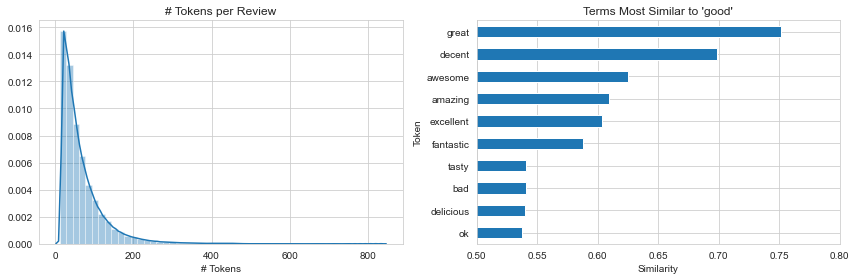

In [50]:
fig, axes =plt.subplots(ncols=2, figsize=(12, 4))
sns.distplot(sample.text.str.split().str.len(), ax=axes[0])
axes[0].set_title('# Tokens per Review')

most_similar.set_index('token').similarity.sort_values().plot.barh(ax=axes[1], 
                                                                   title="Terms Most Similar to 'good'",
                                                                  xlim=(.5, .8))
axes[1].set_xlabel('Similarity')
axes[1].set_ylabel('Token')
axes[0].set_xlabel('# Tokens')

fig.tight_layout()
fig.savefig('figures/doc2vec_stats', dpi=300)

## Persist Model

In [28]:
model = Doc2Vec.load((yelp_path / 'sample.model').as_posix())

## Evaluate

In [29]:
y = sample.stars.sub(1)

In [31]:
size = 300
X = np.zeros(shape=(len(y), size))
for i in range(len(sample)):
    X[i] = model.docvecs[i]

In [32]:
X.shape

(485702, 300)

### Train-Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [34]:
mode = pd.Series(y_train).mode().iloc[0]
baseline = accuracy_score(y_true=y_test, y_pred=np.full_like(y_test, fill_value=mode))
print(f'Baseline Score: {baseline:.2%}')

Baseline Score: 20.15%


In [35]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [36]:
class_weights

array([0.99470343, 0.99241693, 0.99651467, 1.0016524 , 1.01503638])

## LightGBM

In [37]:
train_data = lgb.Dataset(data=X_train, label=y_train)
test_data = train_data.create_valid(X_test, label=y_test)

In [38]:
params = {'objective': 'multiclass',
          'num_classes': 5}

In [39]:
lgb_model = lgb.train(params=params,
                      train_set=train_data,
                      num_boost_round=5000,
                      valid_sets=[train_data, test_data],
                      early_stopping_rounds=25,
                      verbose_eval=50)

Training until validation scores don't improve for 25 rounds
[50]	training's multi_logloss: 1.40574	valid_1's multi_logloss: 1.42219
[100]	training's multi_logloss: 1.32622	valid_1's multi_logloss: 1.35816
[150]	training's multi_logloss: 1.26866	valid_1's multi_logloss: 1.31488
[200]	training's multi_logloss: 1.22222	valid_1's multi_logloss: 1.28157
[250]	training's multi_logloss: 1.18278	valid_1's multi_logloss: 1.25444
[300]	training's multi_logloss: 1.14868	valid_1's multi_logloss: 1.23211
[350]	training's multi_logloss: 1.11928	valid_1's multi_logloss: 1.21423
[400]	training's multi_logloss: 1.09329	valid_1's multi_logloss: 1.19948
[450]	training's multi_logloss: 1.07063	valid_1's multi_logloss: 1.18815
[500]	training's multi_logloss: 1.05052	valid_1's multi_logloss: 1.17887
[550]	training's multi_logloss: 1.03156	valid_1's multi_logloss: 1.1705
[600]	training's multi_logloss: 1.01384	valid_1's multi_logloss: 1.16315
[650]	training's multi_logloss: 0.997402	valid_1's multi_logloss:

In [40]:
lgb_pred = np.argmax(lgb_model.predict(X_test), axis=1)

In [41]:
lgb_acc = accuracy_score(y_true=y_test, y_pred=lgb_pred)
print(f'Accuracy: {lgb_acc:.2%}')

Accuracy: 62.43%


## Random Forest

In [42]:
rf = RandomForestClassifier(n_jobs=-1,  
                            n_estimators=500,
                            class_weight='balanced_subsample')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1)

In [44]:
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_true=y_test, y_pred=rf_pred)
print(f'Accuracy: {rf_acc:.2%}')

Accuracy: 41.37%


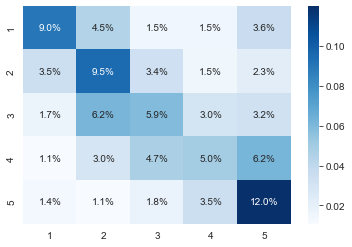

In [45]:
cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%');

## Multinomial Logistic Regression

In [46]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [47]:
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_true=y_test, y_pred=lr_pred)
print(f'Accuracy: {lr_acc:.2%}')

Accuracy: 39.77%


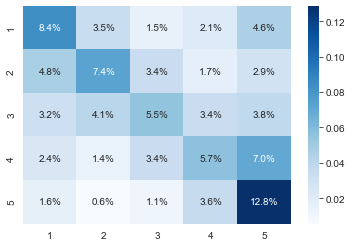

In [48]:
cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%');

## Comparison

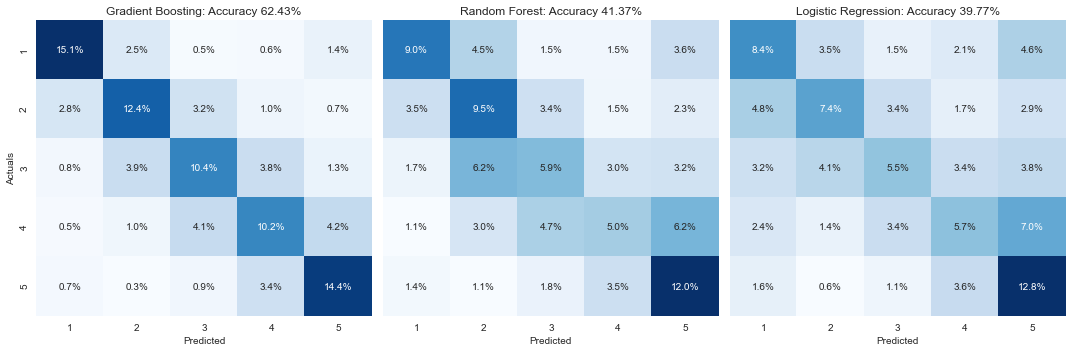

In [49]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

lgb_cm = confusion_matrix(y_true=y_test, y_pred=lgb_pred)
sns.heatmap(pd.DataFrame(lgb_cm/np.sum(lgb_cm), index=stars, columns=stars), 
            annot=True, cmap='Blues', fmt='.1%', ax=axes[0], cbar=False)
axes[0].set_title(f'Gradient Boosting: Accuracy {lgb_acc:.2%}')

rf_cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(rf_cm/np.sum(rf_cm), index=stars, columns=stars), 
            annot=True, cmap='Blues', fmt='.1%', ax=axes[1], cbar=False)
axes[1].set_title(f'Random Forest: Accuracy {rf_acc:.2%}')

lr_cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(lr_cm/np.sum(lr_cm), index=stars, columns=stars), 
            annot=True, cmap='Blues', fmt='.1%', ax=axes[2], cbar=False)
axes[2].set_title(f'Logistic Regression: Accuracy {lr_acc:.2%}')
axes[0].set_ylabel('Actuals')
for i in range(3):
    axes[i].set_xlabel('Predicted')

fig.tight_layout()
# fig.savefig('../figures/confusion_matrix', dpi=300);